# Arrival Time Prediction - Pre Processing
This notebook is the first on the work on GP regression for arrival time prediction and deals with the pre processing before a model can be trained to make predictions.

First off lets get some libraries into scope and load the data. Note that we are ignoring the first segment in the trajectory, since the model has major issues with it. This is because the bus drives around in a small turn on the parking lot, and because it has a very long idle time before it starts its journey.

In [4]:
import numpy as np
import pandas as pd
import time
import pickle
from datetime import datetime
from functools import reduce
import plot

data = pd.read_csv('./bus203_all.csv')
n_journeys = list(data.journey_number.unique())
n_journeys_to_use = 200
journeys_to_use = frozenset(np.random.choice(n_journeys, size=n_journeys_to_use))
data = data[data.journey_number.transform(lambda j: j in journeys_to_use)]
data = data[data.segment_number > 1]
data.head()

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
4594,190,2018-02-16T06:34:06.0000000+01:00,ObservedPositionEvent,5415,0,58.414585,15.565050,243.600006,4.42,NaN,6,2
4595,191,2018-02-16T06:34:07.0000000+01:00,ObservedPositionEvent,5415,0,58.414570,15.564998,242.800003,3.85,NaN,6,2
4596,192,2018-02-16T06:34:08.0000000+01:00,ObservedPositionEvent,5415,0,58.414558,15.564940,241.300003,3.29,NaN,6,2
4597,193,2018-02-16T06:34:09.0000000+01:00,ObservedPositionEvent,5415,0,58.414547,15.564917,241.600006,2.26,NaN,6,2
4598,194,2018-02-16T06:34:10.0000000+01:00,ObservedPositionEvent,5415,0,58.414547,15.564896,241.600006,0.66,NaN,6,2


The names in the csv are very verbose, so we'll shorten them. This is of course a matter of preference but I prefer it this way.

In [5]:
data = data.rename(columns = {
                        'latitude': 'lat', 
                        'longitude': 'lon', 
                        'journey_number': 'traj', 
                        'segment_number': 'seg', 
                        'speed': 'speed',
                        'event': 'event',
                        'timestamp': 'timestamp'
                    })
data.head()
data = data.sort_values(['traj', 'seg', 'timestamp'])

## Stop Compression
There are many times where busses stop or drive very slowly. This causes a lot of data points to be clustered which will cause the GPs to prioritise getting the clustered areas right more than other areas, which we do not want. To prevent this we will filter out data points in every trajectory that are too close by some delta. However simply throwing the points aray will leave massive gaps in between them, which will not work at all for a GP with constant kernel lengthscale (which we will use). To combat this we will compress the data points during stops to a single data point which takes the mean value of all points during a stop.

Worth noting is that coordinates are not in euclidian space but on a spherical surface so pythagoras theorem is no good here and we have to turn to haversine distance.

In [26]:
from math import radians, cos, sin, asin, sqrt, isnan
 
def parse_time(dt_str):
    dt, _, _ = dt_str.partition(".")
    return datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
 
def haversine(lon1, lat1, lon2, lat2):
    """
   Calculate the great circle distance between two points
   on the earth (specified in decimal degrees)
   """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r
 
def as_dict(d):
    return {
        'lat': d.lat,
        'lon': d.lon,
        'seg': d.seg,
        'speed': d.speed,
        'traj': int(d.traj),
        'timestamp': d.timestamp,
        'event': d.event
    }
 
 
# I have no idea why, but this consistently returns one hour too much.
# Also, we actually call to_datetime twice (one more time outside of the function)
# which seems to be needed. No clue why this is the case.
def mean_timestamp(timestamps):
    dt = pd.to_datetime(timestamps.dropna().astype(np.int64).mean())
    dt = dt - pd.Timedelta(hours=1)
    return dt
 
def compress(data):
    dict_data = [as_dict(x) for x in data]
   
    if len(dict_data) == 1: return dict_data[0]
   
    df = pd.DataFrame(dict_data)
   
    df.speed = np.max(df.speed, 0) # data contains -1 sentinel values for missing speed
 
    df2 = df.drop(['timestamp', 'event', 'seg'], axis=1).apply(np.mean, axis=0)
    df2['timestamp'] = mean_timestamp(df['timestamp'].apply(parse_time))
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])
   
    contains_entered_event = lambda df : df.event.transform(lambda e : e == 'EnteredEvent').any()
    df2['event'] = 'EnteredEvent' if contains_entered_event(df) else 'ObservedPositionEvent'
    df2['seg'] = df.seg.min() # In the case of overlapping segments we let the data belong to the first
 
    return as_dict(df2)
   
t0 = time.time()
delta = 4e-3 # approx. 4 metres
output = []
buffer = [ data.iloc[0] ]
for current in data.itertuples():
    if current.Index == 0: continue
       
    distance = haversine(current.lat, current.lon, buffer[-1].lat, buffer[-1].lon)
   
    if distance > delta:
        output.append(compress(buffer))
        buffer.clear()
   
    buffer.append(current)
 
if len(buffer) > 0: 
    output.append(compress(buffer))
 
compressed_data = pd.DataFrame(output)
 
elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")
compressed_data.head()

Data processed in 43.5167920589447  seconds


,event,lat,lon,seg,speed,timestamp,traj
0,ObservedPositionEvent,15.564912,58.414558,2,4.42,2018-02-16 05:34:17.785714432,6
1,DepartedEvent,15.564575,58.414410,2,-1.00,2018-02-16 05:34:31.000000000,6
2,ObservedPositionEvent,15.564827,58.414523,2,3.60,2018-02-16 05:34:34.500000000,6
3,ObservedPositionEvent,15.564676,58.414452,2,3.96,2018-02-16 05:34:38.000000000,6
4,ObservedPositionEvent,15.564575,58.414410,2,5.76,2018-02-16 05:34:38.500000000,6


## Computing arrival times
The goal is to estimate arrival time given a trajectory, but to do that we first need to annotate the trajectories in the data with the actual arrival times. In this case we are going to add a field for "time_left". In addition we are going to need to know the _progression_ of each trajectory, which is computed by normalising over the indicies of a trajectory. This is needed to train a synchronisation GP before making the predictions. Observe that this is done after stop compression, which means that we assume that the information lost on how long a trajectory is spatially stationary is irrelevant for our predictions. The following chunk annotates the data with time remaining and normalised temporal progression.

In [27]:
t0 = time.time()
time_left = pd.DataFrame({'time_left': np.zeros(compressed_data.shape[0])})
progress = pd.DataFrame({'progress': np.zeros(compressed_data.shape[0])})
reverse_rows = compressed_data.iloc[::-1]
last_stop_timestamp = reverse_rows.iloc[0].timestamp
trajs = compressed_data.traj.unique()
segs = compressed_data.seg.unique()

sdata = compressed_data.sort_values(['traj', 'seg', 'timestamp'])
cur_traj = 0
cur_seg = 0
tn = 0
seg0 = 0
segn = 0
traj = sdata
for i, d in sdata.iterrows():
    if d.traj > cur_traj:
        cur_seg = 0
        cur_traj = d.traj
        traj = sdata[sdata.traj == cur_traj]
        
    if d.seg > cur_seg:
        cur_seg = d.seg
        seg0 = i
        seg = traj[traj.seg == cur_seg]
        segn = seg.shape[0]
        tn = seg.iloc[-1].timestamp
                      
    time_left.iloc[i] = (tn - d.timestamp).seconds
    progress.iloc[i]  = (i - seg0) / (segn - 1)

progress_data = pd.concat([
            compressed_data[['lat', 'lon', 'traj', 'seg', 'speed']],
            time_left,
            progress],
            axis = 1)
progress_data.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.564912,58.414558,6,2,4.42,53.0,0.000000
1,15.564575,58.414410,6,2,-1.00,40.0,0.027778
2,15.564827,58.414523,6,2,3.60,36.0,0.055556
3,15.564676,58.414452,6,2,3.96,33.0,0.083333
4,15.564575,58.414410,6,2,5.76,32.0,0.111111


Below is a plot of the synchronised progression and spatial trajectory to give some feeling of what is going on.

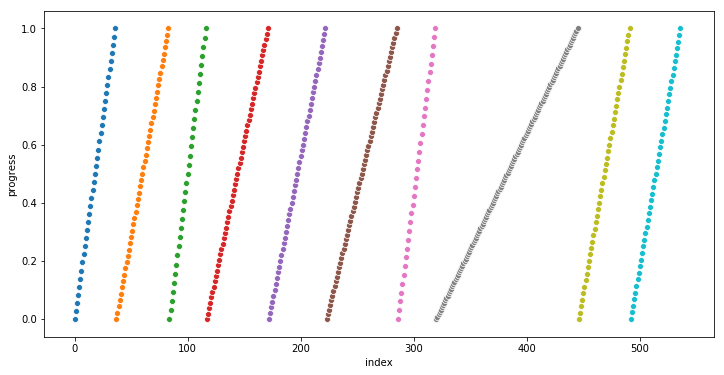

In [28]:
traj_to_plot = progress_data[progress_data.traj == 6]
plot.traj_progress(traj_to_plot)

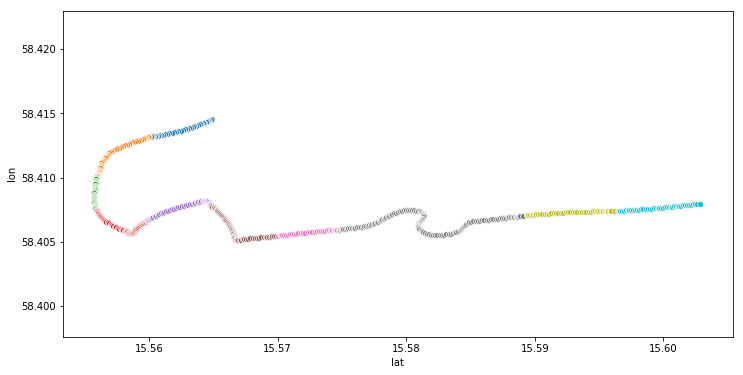

In [29]:
plot.traj_segments(traj_to_plot)

## Enforce smoothness
A property that we want from the synchroinisation GP that we will train is for it to be a smooth mapping with respect to spatial progress, that is, we want regions that are close progressionwise in the functions domain to be close in its codomain. This is not something a GP guarantees at all, so to force it to learn something closer to what we want, extra data is generated by drawing from a normal distribution which is orthogonal to the spatial progression in each data point. By letting these points take on the same progression value we force the GP to not deviate. We call these data points support data points, and they are saved in their own data set.

This is meaningful only for training data, so at this point we split the data into train and test sets.

In [30]:
n_train = round(n_trajs*0.8)
train_ixs = frozenset(np.random.choice(progress_data.traj.unique(), n_train))
train_data = progress_data[progress_data.traj.transform(lambda x: x in train_ixs)]
test_data = progress_data[progress_data.traj.transform(lambda x: x not in train_ixs)]
train_data.to_pickle('train.pkl')
test_data.to_pickle('test.pkl')

In [32]:
from numpy.linalg import norm
tmp_data = []
N = train_data.shape[0]
t0 = time.time()
d = 10 # amount of random draws

def move_to(data, lat, lon):
    data.lat = lat
    data.lon = lon
    return data

for n in range(N-1):
    cur = train_data.iloc[n]
    nxt = train_data.iloc[n+1]
    d_lat = nxt.lat - cur.lat
    d_lon = nxt.lon - cur.lon
    u = np.array([-d_lon, d_lat]) # orthogonal to progression 
    u = u/norm(u)
    
    v = np.array([cur.lat, cur.lon]) # current data point position
    sigma = 9e-5 # taken by simply looking at the results for something that looks decent
    draws = np.random.normal(0, sigma, d)
    support_latlon = [v + u*draw for draw in draws]
    
    support_data = [move_to(cur.copy(), lat, lon) for lat, lon in support_latlon]
    tmp_data = tmp_data + support_data
    
support_data = pd.DataFrame(tmp_data)
support_data.to_pickle('support.pkl')

elapsed = time.time() - t0
print("Data processed in", elapsed, " seconds")

traj_plot_n = 5
traj_to_plot = progress_data[progress_data.traj == traj_plot_n]
sup_to_plot = support_data[support_data.traj == traj_plot_n]
plot.traj_segment_grid(sup_to_plot, 'lat', 'lon', hue='progress')

Data processed in 626.5343239307404  seconds
